In [1]:
from odds import OD
from test_data import generate_test
import datetime
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from utils import auc, fps, TimeoutException
import os
import numpy as np
import stopit
import pandas as pd

In [2]:
n = 100
p = 32

gamma = 0.05
p_frac = 0.3
p_quant = 0.3
r = 20

os.makedirs("./images/", exist_ok=True)


In [33]:
def test_algo(X, outs, algo, metric):
    """
    takes in algorithm 'algo', data 'X', with outlier indices 'outs'
    returns fps and auc score, defined in the list of metrics 'metric'
    algo must have input only X
    """
    outlier_scores = algo(X)
    fps = metric[1](outlier_scores, outs)
    aucs = metric[0](outlier_scores, outs)

    return fps, aucs

def get_all_data_noise(timestamp):

    fname = './results/{}_noise_all.txt'.format(timestamp)
    df = pd.read_csv(fname, sep=',',skipinitialspace=True, index_col=False, header=0)#, names=['timestamp', 'o_type','algo', 'ta',  'p_frac', 'p_quant', 'n_runs', 'total_n_runs', 'noise_list', 'total_time', 'fp_score', 'auc_score'])

    # print(df)
    df.ta = df.ta.astype('str')
    df.n = df.n.astype('str')
    df.p = df.p.astype('str')
    df.noise = df.noise.astype('str')
    n_runs = int(df.columns[-1])


    maxes = df.max(axis=1, skipna=True, numeric_only=True)
    mins = df.min(axis=1, skipna=True, numeric_only=True)
    avg = df.mean(axis=1, skipna=True, numeric_only=True)
    df['ub'] = maxes - avg
    df['lb'] = avg - mins
    df['means'] = avg
    df = df.round(2)

    dfm=df.drop([str(x) for x in (np.arange(n_runs)+1)], axis=1)
    dfm['mean'] = avg
    dfr = dfm.pivot_table(index='algo', columns=['score','ta'], values='mean')
    dfr = dfr.round(2)
    return df, dfm, dfr


def run_noise(p_frac, p_quant, r, gamma, noise_list, ta, n, p, n_runs,algo_list,
                metric, metric_str, timeout, timestamp):
    t0 = time()

    for i in range(len(algo_list)):
        t1 = time()
        algo = algo_list[i]
        od = OD(algo)

        print('{}'.format(algo))
        fpz, aucz = get_auc_noise(p_frac, p_quant, r, noise_list, ta, n, p, n_runs,
                                    gamma,od.get_os, algo, metric, timeout,timestamp)

        label = ' ta_{}'.format(ta)
        t2 = time()-t1

        print('Algorithm {} with ta {} took {}m and {}s to run {} times'.format(algo,
                                                                    ta,
                                                                    int(t2//60),
                                                                    int(t2%60),
                                                                    len(noise_list)*n_runs))
    t3 = time()-t0
    print('Took {}m {}s to run all algorithms'.format(int(t3//60),int(t3%60)))
    return

def get_auc_noise(p_frac, p_quant, r, noise_list, ta, n, p, n_runs, gamma,algo, algo_str, metric, timeout, timestamp):
    """
    runs each algorithm with varying amounts of noise on ta given.
    """
    all_name = './results/{}_noise_all.txt'.format(timestamp)
    if not os.path.exists('results'):
        os.mkdir('results')
    if not os.path.isfile(all_name):
        with open(all_name, 'w') as f:
            info = '{}, {}, {}, {}, {}, {}, '.format('algo','ta', 'n', 'p','score', 'noise')
            info2 = ''.join(['%d, '])*n_runs%tuple(np.arange(n_runs)+1)
            f.write(info+info2[:-2]+'\n')
    fps = []
    aucs = []
    for noise in noise_list:
        Fail = False
        t0 = time()
        fp_runs=[]
        auc_runs=[]
        succeed=True

        for i in range(n_runs):
            la_err = True
            while la_err and succeed:
                try:
                    X, outs = generate_test(n, p, r, p_frac, p_quant, gamma, noise, ta=ta)
                    with stopit.ThreadingTimeout(timeout) as ctx_mgr:
                        fp, auc = test_algo(X, outs, algo, metric)
                    if ctx_mgr.state==ctx_mgr.TIMED_OUT:
                        raise TimeoutException(timeout)
                    la_err = False
                    # print('got to end of try')

                except np.linalg.LinAlgError as err:
                    if 'Singular matrix' in str(err):
                        la_err = True
                        print('redoing due to singular matrix err')
                    else:
                        # print(err)
                        print('some other linalg error')
                        raise(err)
                except TimeoutException as err:
                    # print('timeout after {}s'.format(timeout))
                    succeed = False

            if succeed:
                fp_runs.append(fp)
                auc_runs.append(auc)

            else:
                break
        t1 = time() - t0
        if Fail:
            Fail = False
            fp_row.append(np.nan)
            auc_row.append(np.nan)
            print('n={}, p={}, Failed, LinAlgError'.format(n, p))
        elif not succeed:
            print('n={}, p={}, Failed, Timeout after {}s'.format(n, p, timeout))
            fp_row.append(np.nan)
            auc_row.append(np.nan)
            with open(all_name, 'a') as f:
                fp_str = '{}, {}, {}, {}, {}, {}\n'.format(algo_str, ta, 'fps',n,p, np.nan)
                auc_str = '{}, {}, {}, {}, {}, {}\n'.format(algo_str, ta, 'auc',n,p, np.nan)
                f.write(fp_str)
                f.write(auc_str)
        else:
            fps.append(np.mean(fp_runs))
            aucs.append(np.mean(auc_runs))
            with open(all_name, 'a') as f:
                fp_str = '{}, {}, {}, {}, {}, {}, '.format(algo_str, ta, n,p,'fps',noise)
                fp_str = fp_str+''.join(['%0.3f, '])*len(fp_runs)%tuple(fp_runs)+'\n'
                auc_str = '{}, {}, {}, {}, {}, {}, '.format(algo_str, ta, n,p,'auc',noise)
                auc_str = auc_str+''.join(['%0.3f, '])*len(auc_runs)%tuple(auc_runs)+'\n'
                f.write(fp_str)
                f.write(auc_str)

            print('noise={}, runs={}, time= {}m {}s'.format(noise, n_runs, int(t1//60),int(t1%60)))
    fpz = np.array(fps)
    aucz = np.array(aucs)

    return fpz, aucz


def get_noise_plot(algo_list, ta, df, score, n_runs):

    runs_lst = np.arange(n_runs)+1
    plt.figure()
    dfa = pd.DataFrame()
    noises = []
    means=[]
    ubs=[]
    lbs=[]
    algos=[]
    # print(df)
    for ind, row in df.iterrows():
        algo = row['algo']
        ta_r = row['ta']
        score_r = row['score']
        # print(algo, ta_r, score_r)
        # print(algo in algo_list, ta_r ==str(ta), score_r==score)

        if algo in algo_list and ta_r==str(ta) and score_r==score:
            noises.append(float(row['noise']))
            means.append(row['means'])
            ubs.append(row['ub'])
            lbs.append(row['lb'])
            algos.append(algo)

    dfa['algo'] = algos
    dfa['noise'] = noises
    dfa['means'] = means
    dfa['ub'] = ubs
    dfa['lb'] = lbs
    # print(dfa)

    for algo in algo_list:
        algo_df = dfa[dfa['algo']==algo]
#         print(algo_df)
        if algo == 'Ridge':
            lab = 'FRR'
        else:
            lab = algo
        plt.errorbar(algo_df.noise, algo_df.means, yerr=(algo_df.lb, algo_df.ub), label=lab, capsize=5, capthick=1)
    plt.title('D{}'.format(ta))
    plt.legend()
    if score == 'auc':
        plt.axis([0,1,0.4,1.05])
    else:
        #ie score is fps
        plt.axis([0,1,0,1.05])
    plt.xlabel('noise')
    plt.ylabel(score)
    plt.savefig('./images/comp_noise_ta{}_{}.png'.format(ta, score))
    plt.show()

def do_better_noise_boxplot(algo_lst, ta, dfb):
    """
    
    """
    nx = len(algo_lst)
    ny = 1
    
    fig, axs = plt.subplots(nx, ny, figsize=(10,8))

    for i, algo in enumerate(algo_lst):
            
        df_fps = dfb[dfb.metric=='fps']
        df_auc = dfb[dfb.metric=='auc']
        
        df_fps = df_fps[df_fps.ta==str(ta)]
        df_auc = df_auc[df_auc.ta==str(ta)]
#         print(df_fps)
#         print(df_auc)
        df_fps.index=df_fps.noise
        df_auc.index=df_auc.noise
        df_fps = df_fps[df_fps.algo==algo]
        df_auc = df_auc[df_auc.algo==algo]


        df_fps = df_fps.drop(['algo', 'metric', 'ta', 'noise'], axis=1)
        df_auc = df_auc.drop(['algo',  'metric', 'ta', 'noise'], axis=1)
#         print(df_auc.info())
#         print(df_auc.head())
        
        labels = list(df_fps.index)
        df_fps = df_fps.transpose()
        df_auc=df_auc.transpose()

        bp1 = box_plot(axs[i], df_fps, 'red', 'tan')
        bp2 = box_plot(axs[i], df_auc, 'blue', 'cyan')
        axs[i].legend([bp1["boxes"][0], bp2["boxes"][0]], ['FPR', 'AUC'], loc='lower right')
        if algo=='Ridge':
            axs[i].annotate('FRR', (1,0.7), fontsize=14)
        else:
            axs[i].annotate(algo, (1,0.8), fontsize=14)
        lab_inds = list(range(1,len(labels)+2, 4))
#         print(lab_inds)
        labels = [labels[ind-1] for ind in lab_inds]
#         print(labels)
        axs[i].set_xticks(lab_inds)
        axs[i].set_xticklabels(labels, fontsize=14)
        axs[i].set_xlabel('Noise factor $\sigma$', fontsize=14)
        axs[i].set_ylabel('Score', fontsize=14)
        axs[i].set_ylim(-0.1,1.1)
        
#     plt.title('Boxplots for {}'.format(ta))
    
    plt.savefig('better_boxplots_{}.png'.format(ta), bbox_inches='tight')
    plt.show()
    plt.close()

def box_plot(ax, data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        if element =='fliers':
            plt.setp(bp[element], color=edge_color, markeredgecolor=edge_color)
        else:
            plt.setp(bp[element], color=edge_color)
        

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

def run_noise_experiment_3(timestamp):
    """
    to run experiment 3 varying noise as in the paper.
    """
    algo_lst = ['VAR', 'FRO', 'FRL', 'FRR', 'OCSVM', 'GMM', 'DBSCAN', 'IF','AE', 'VAE', 'LSTM', 'GRU', 'OP', 'GOP']
#     algo_lst = ['LSTM', 'GRU', 'OP', 'GOP']
    #set parameters
    #for data
    r = 20 # rank of lower d subspace for D1 and D2.
    p_frac = 0.3 #fraction of features in outliers that are outlying.
    p_quant = 0.3 # extend to which those features are changed.
    gamma = 0.05 #fraction that are outliers.
    noise=.1
    n = 1000
    p = 32
    #for expt
    timeout = 900 #experiment will time out in this num seconds.
    n_runs = 20
    noise_list=np.arange(0,1.01,0.05)
    ta_lst = [1,2,3,4,5,6]



    ## for Testing
#     algo_lst=['VAR', 'FRO', 'FRL', 'FRR', 'OCSVM']
#     n_runs=2
#     ta_lst = [1, 2]
    ## end of testing section

    metric_lst = [auc, fps]
    metric_str_lst = ['AUC', 'FPs']
    print(timestamp)
    for ta in ta_lst:

        run_noise(p_frac, p_quant, r, gamma, noise_list, ta, n, p, n_runs, algo_lst,
                         metric_lst, metric_str_lst, timeout, timestamp)
    df, dfm, dfr = get_all_data_noise(timestamp) #reads results from file.
    print(dfr)
    algo_list = ['FRR', 'VAR', 'OCSVM']
    ta=1
    score = 'auc'
    get_noise_plot(algo_list, ta, df, score, n_runs)

def get_box_data(df, runs):
    """
    get data for better box plots
    """
    noise_lst = np.arange(runs)+1
    dfb = pd.DataFrame()
    noises = []
    algos=[]
    results = [[] for i in range(runs)]
    tas = []
    metrics = []
    for ind, row in df.iterrows():
        algo = row['algo']
        ta = row['ta']
        score = row['score']
        
        noises.append(round(float(row['noise']), 2))
        algos.append(algo)
        res = np.array([float(x) for x in row[list(noise_lst+5)] ])
        for i in range(runs):
            results[i].append(float(res[i]))
#         results.append(res)
        tas.append(ta)
        metrics.append(score)

    dfb['algo'] = algos
    dfb['noise'] = noises
    dfb['ta'] = tas
    dfb['metric'] = metrics
    
    for i in range(runs):
        dfb[str(i)] = results[i]
#     dfb['results'] =results
    return dfb



To get results plots for expt 3:

In [36]:
timestamp = '2022-07-14_09-41-03'
df, dfm, dfr = get_all_data_noise(timestamp)
print(dfr)

score    auc                                 fps                              
ta         1     2     3     4     5     6     1     2     3     4     5     6
algo                                                                          
AE      0.84  0.84  0.85  0.79  0.83  0.74  0.76  0.78  0.72  0.93  0.77  0.95
DBSCAN  0.64  0.65  0.64  0.57  0.64  0.50  0.72  0.72  0.72  0.94  0.71  0.95
FRL     0.70  0.81  0.88  0.55  0.55  0.81  0.94  0.91  0.86  0.95  0.94  0.93
FRO     0.90  0.91  0.90  0.87  0.91  0.81  0.60  0.60  0.62  0.87  0.60  0.94
FRR     0.90  0.91  0.90  0.87  0.91  0.81  0.59  0.60  0.63  0.86  0.59  0.94
GMM     0.89  0.86  0.90  0.86  0.85  0.80  0.67  0.77  0.64  0.89  0.78  0.94
GOP     0.71  0.71  0.70  0.66  0.70  0.56  0.78  0.70  0.74  0.96  0.95  0.95
GRU     0.89  0.81  0.87  0.87  0.81  0.81  0.75  0.91  0.86  0.87  0.82  0.94
IF      0.81  0.83  0.85  0.79  0.79  0.76  0.86  0.86  0.81  0.90  0.79  0.94
LSTM    0.82  0.81  0.86  0.88  0.82  0.81  0.88  0.

Boxplots for dataset 1


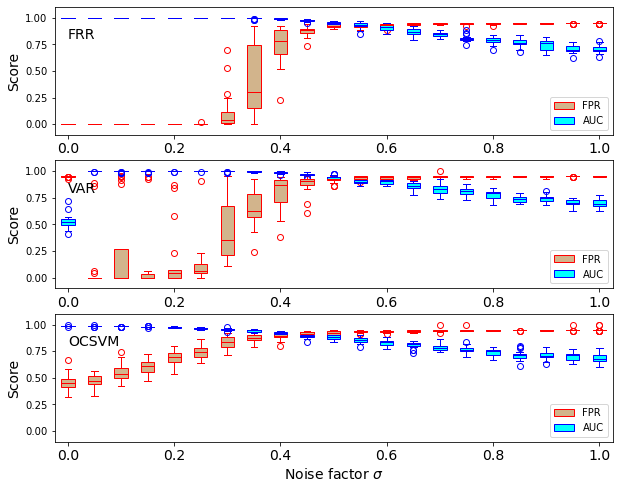

Boxplots for dataset 2


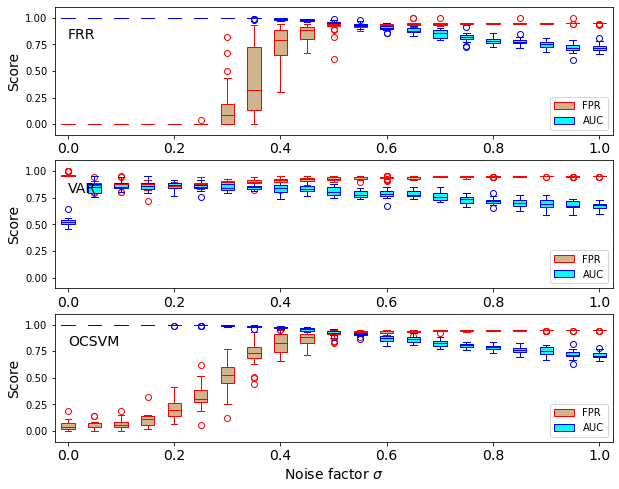

Boxplots for dataset 3


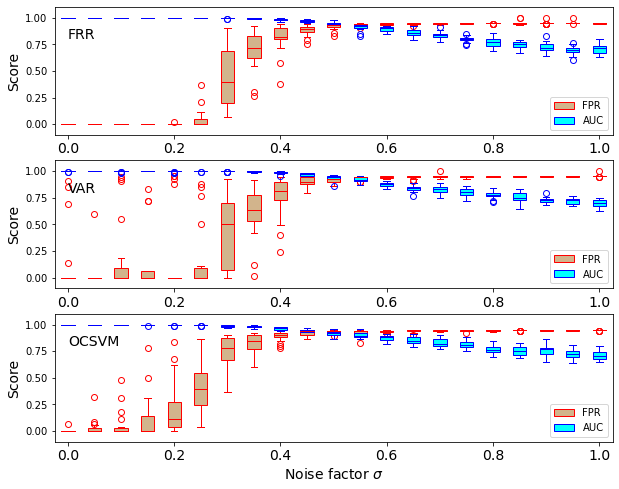

Boxplots for dataset 4


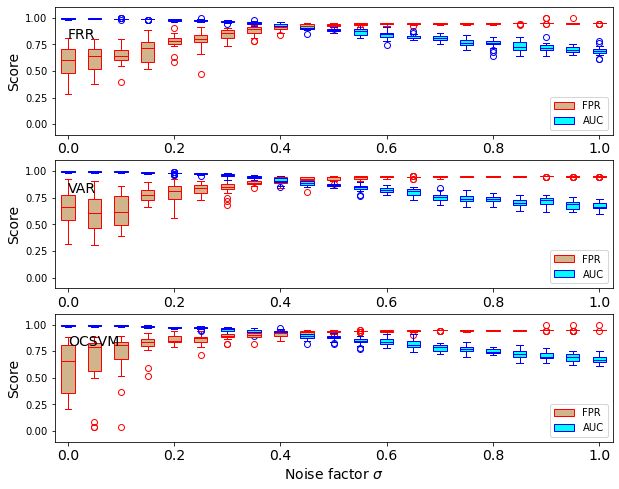

Boxplots for dataset 5


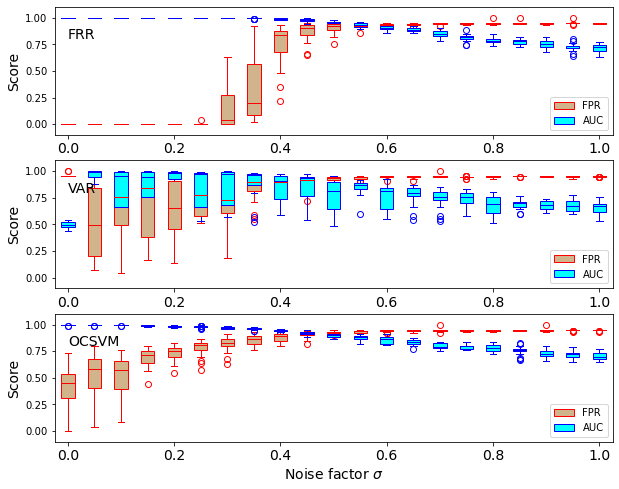

Boxplots for dataset 6


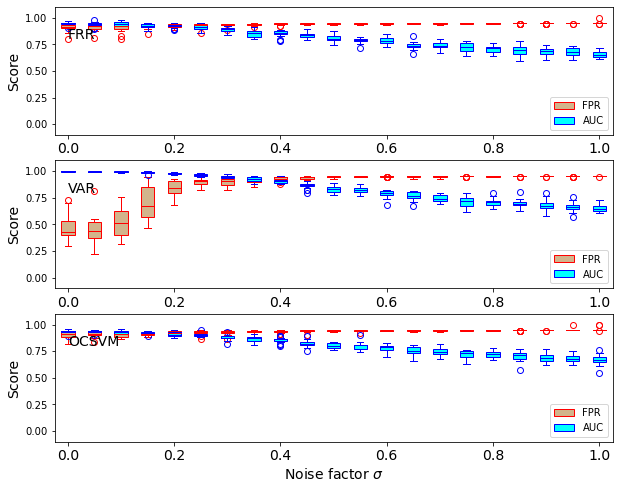

In [38]:
algo_list = ['FRR', 'VAR', 'OCSVM']
ta=1
# score = 'auc'
runs=20
for ta in [1,2,3,4,5,6]:
    print(f'Boxplots for dataset {ta}')
    dfb = get_box_data(df, runs)
    do_better_noise_boxplot(algo_list, ta, dfb)

To run the experiments again, run the box below:

2022-07-14_09-41-03
2022-07-14_09-41-03
VAR
noise=0.0, runs=20, time= 0m 2s
noise=0.05, runs=20, time= 0m 1s
noise=0.1, runs=20, time= 0m 1s
noise=0.15000000000000002, runs=20, time= 0m 1s
noise=0.2, runs=20, time= 0m 1s
noise=0.25, runs=20, time= 0m 0s
noise=0.30000000000000004, runs=20, time= 0m 1s
noise=0.35000000000000003, runs=20, time= 0m 1s
noise=0.4, runs=20, time= 0m 1s
noise=0.45, runs=20, time= 0m 1s
noise=0.5, runs=20, time= 0m 1s
noise=0.55, runs=20, time= 0m 1s
noise=0.6000000000000001, runs=20, time= 0m 1s
noise=0.65, runs=20, time= 0m 2s
noise=0.7000000000000001, runs=20, time= 0m 1s
noise=0.75, runs=20, time= 0m 1s
noise=0.8, runs=20, time= 0m 1s
noise=0.8500000000000001, runs=20, time= 0m 1s
noise=0.9, runs=20, time= 0m 3s
noise=0.9500000000000001, runs=20, time= 0m 2s
noise=1.0, runs=20, time= 0m 2s
Algorithm VAR with ta 1 took 0m and 36s to run 420 times
FRO
noise=0.0, runs=20, time= 0m 1s
noise=0.05, runs=20, time= 0m 0s
noise=0.1, runs=20, time= 0m 1s
noise=0.1500

noise=0.7000000000000001, runs=20, time= 3m 6s
noise=0.75, runs=20, time= 2m 57s
noise=0.8, runs=20, time= 3m 7s
noise=0.8500000000000001, runs=20, time= 3m 7s
noise=0.9, runs=20, time= 3m 16s
noise=0.9500000000000001, runs=20, time= 3m 25s
noise=1.0, runs=20, time= 3m 12s
Algorithm VAE with ta 1 took 66m and 39s to run 420 times
LSTM
noise=0.0, runs=20, time= 1m 40s
noise=0.05, runs=20, time= 1m 36s
noise=0.1, runs=20, time= 1m 37s
noise=0.15000000000000002, runs=20, time= 1m 37s
noise=0.2, runs=20, time= 1m 36s
noise=0.25, runs=20, time= 1m 39s
noise=0.30000000000000004, runs=20, time= 1m 37s
noise=0.35000000000000003, runs=20, time= 1m 39s
noise=0.4, runs=20, time= 1m 35s
noise=0.45, runs=20, time= 1m 34s
noise=0.5, runs=20, time= 1m 34s
noise=0.55, runs=20, time= 1m 34s
noise=0.6000000000000001, runs=20, time= 1m 34s
noise=0.65, runs=20, time= 1m 33s
noise=0.7000000000000001, runs=20, time= 1m 34s
noise=0.75, runs=20, time= 1m 33s
noise=0.8, runs=20, time= 1m 38s
noise=0.8500000000

noise=0.2, runs=20, time= 0m 4s


/Users/jojo/anaconda3/envs/pe38/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/Users/jojo/anaconda3/envs/pe38/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


noise=0.25, runs=20, time= 0m 5s
noise=0.30000000000000004, runs=20, time= 0m 4s
noise=0.35000000000000003, runs=20, time= 0m 3s


/Users/jojo/anaconda3/envs/pe38/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


noise=0.4, runs=20, time= 0m 5s
noise=0.45, runs=20, time= 0m 4s
noise=0.5, runs=20, time= 0m 4s
noise=0.55, runs=20, time= 0m 4s
noise=0.6000000000000001, runs=20, time= 0m 4s
noise=0.65, runs=20, time= 0m 4s
noise=0.7000000000000001, runs=20, time= 0m 4s
noise=0.75, runs=20, time= 0m 4s
noise=0.8, runs=20, time= 0m 5s
noise=0.8500000000000001, runs=20, time= 0m 4s
noise=0.9, runs=20, time= 0m 4s
noise=0.9500000000000001, runs=20, time= 0m 4s
noise=1.0, runs=20, time= 0m 4s
Algorithm GMM with ta 2 took 1m and 29s to run 420 times
DBSCAN
noise=0.0, runs=20, time= 0m 0s
noise=0.05, runs=20, time= 0m 0s
noise=0.1, runs=20, time= 0m 0s
noise=0.15000000000000002, runs=20, time= 0m 0s
noise=0.2, runs=20, time= 0m 0s
noise=0.25, runs=20, time= 0m 0s
noise=0.30000000000000004, runs=20, time= 0m 1s
noise=0.35000000000000003, runs=20, time= 0m 1s
noise=0.4, runs=20, time= 0m 1s
noise=0.45, runs=20, time= 0m 1s
noise=0.5, runs=20, time= 0m 1s
noise=0.55, runs=20, time= 0m 1s
noise=0.600000000000

noise=1.0, runs=20, time= 0m 1s
Algorithm VAR with ta 3 took 0m and 31s to run 420 times
FRO
noise=0.0, runs=20, time= 0m 0s
noise=0.05, runs=20, time= 0m 1s
noise=0.1, runs=20, time= 0m 1s
noise=0.15000000000000002, runs=20, time= 0m 1s
noise=0.2, runs=20, time= 0m 0s
noise=0.25, runs=20, time= 0m 0s
noise=0.30000000000000004, runs=20, time= 0m 1s
noise=0.35000000000000003, runs=20, time= 0m 1s
noise=0.4, runs=20, time= 0m 1s
noise=0.45, runs=20, time= 0m 1s
noise=0.5, runs=20, time= 0m 1s
noise=0.55, runs=20, time= 0m 1s
noise=0.6000000000000001, runs=20, time= 0m 1s
noise=0.65, runs=20, time= 0m 1s
noise=0.7000000000000001, runs=20, time= 0m 1s
noise=0.75, runs=20, time= 0m 1s
noise=0.8, runs=20, time= 0m 1s
noise=0.8500000000000001, runs=20, time= 0m 1s
noise=0.9, runs=20, time= 0m 1s
noise=0.9500000000000001, runs=20, time= 0m 1s
noise=1.0, runs=20, time= 0m 1s
Algorithm FRO with ta 3 took 0m and 29s to run 420 times
FRL
noise=0.0, runs=20, time= 0m 0s
noise=0.05, runs=20, time= 0

noise=0.6000000000000001, runs=20, time= 1m 39s
noise=0.65, runs=20, time= 1m 39s
noise=0.7000000000000001, runs=20, time= 1m 40s
noise=0.75, runs=20, time= 1m 39s
noise=0.8, runs=20, time= 1m 40s
noise=0.8500000000000001, runs=20, time= 1m 40s
noise=0.9, runs=20, time= 1m 43s
noise=0.9500000000000001, runs=20, time= 1m 45s
noise=1.0, runs=20, time= 1m 41s
Algorithm LSTM with ta 3 took 35m and 6s to run 420 times
GRU
noise=0.0, runs=20, time= 1m 39s
noise=0.05, runs=20, time= 1m 40s
noise=0.1, runs=20, time= 1m 45s
noise=0.15000000000000002, runs=20, time= 1m 45s
noise=0.2, runs=20, time= 1m 40s
noise=0.25, runs=20, time= 1m 42s
noise=0.30000000000000004, runs=20, time= 1m 38s
noise=0.35000000000000003, runs=20, time= 1m 39s
noise=0.4, runs=20, time= 1m 40s
noise=0.45, runs=20, time= 1m 41s
noise=0.5, runs=20, time= 1m 40s
noise=0.55, runs=20, time= 1m 37s
noise=0.6000000000000001, runs=20, time= 1m 47s
noise=0.65, runs=20, time= 1m 43s
noise=0.7000000000000001, runs=20, time= 1m 38s
n

noise=0.1, runs=20, time= 0m 0s
noise=0.15000000000000002, runs=20, time= 0m 0s
noise=0.2, runs=20, time= 0m 0s
noise=0.25, runs=20, time= 0m 0s
noise=0.30000000000000004, runs=20, time= 0m 1s
noise=0.35000000000000003, runs=20, time= 0m 1s
noise=0.4, runs=20, time= 0m 1s
noise=0.45, runs=20, time= 0m 1s
noise=0.5, runs=20, time= 0m 1s
noise=0.55, runs=20, time= 0m 1s
noise=0.6000000000000001, runs=20, time= 0m 1s
noise=0.65, runs=20, time= 0m 1s
noise=0.7000000000000001, runs=20, time= 0m 1s
noise=0.75, runs=20, time= 0m 1s
noise=0.8, runs=20, time= 0m 1s
noise=0.8500000000000001, runs=20, time= 0m 1s
noise=0.9, runs=20, time= 0m 1s
noise=0.9500000000000001, runs=20, time= 0m 1s
noise=1.0, runs=20, time= 0m 1s
Algorithm DBSCAN with ta 4 took 0m and 21s to run 420 times
IF
noise=0.0, runs=20, time= 0m 3s
noise=0.05, runs=20, time= 0m 3s
noise=0.1, runs=20, time= 0m 3s
noise=0.15000000000000002, runs=20, time= 0m 3s
noise=0.2, runs=20, time= 0m 3s
noise=0.25, runs=20, time= 0m 3s
noise=

redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singular matrix err
redoing due to singu

noise=0.15000000000000002, runs=20, time= 0m 1s
noise=0.2, runs=20, time= 0m 1s
noise=0.25, runs=20, time= 0m 1s
noise=0.30000000000000004, runs=20, time= 0m 1s
noise=0.35000000000000003, runs=20, time= 0m 1s
noise=0.4, runs=20, time= 0m 1s
noise=0.45, runs=20, time= 0m 1s
noise=0.5, runs=20, time= 0m 1s
noise=0.55, runs=20, time= 0m 1s
noise=0.6000000000000001, runs=20, time= 0m 1s
noise=0.65, runs=20, time= 0m 1s
noise=0.7000000000000001, runs=20, time= 0m 1s
noise=0.75, runs=20, time= 0m 1s
noise=0.8, runs=20, time= 0m 1s
noise=0.8500000000000001, runs=20, time= 0m 1s
noise=0.9, runs=20, time= 0m 1s
noise=0.9500000000000001, runs=20, time= 0m 1s
noise=1.0, runs=20, time= 0m 1s
Algorithm FRL with ta 5 took 0m and 32s to run 420 times
FRR
noise=0.0, runs=20, time= 0m 0s
noise=0.05, runs=20, time= 0m 0s
noise=0.1, runs=20, time= 0m 0s
noise=0.15000000000000002, runs=20, time= 0m 0s
noise=0.2, runs=20, time= 0m 0s
noise=0.25, runs=20, time= 0m 0s
noise=0.30000000000000004, runs=20, time

/Users/jojo/anaconda3/envs/pe38/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


noise=0.2, runs=20, time= 0m 3s


/Users/jojo/anaconda3/envs/pe38/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/Users/jojo/anaconda3/envs/pe38/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/Users/jojo/anaconda3/envs/pe38/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/Users/jojo/anaconda3/envs/pe38/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not conv

noise=0.25, runs=20, time= 0m 4s
noise=0.30000000000000004, runs=20, time= 0m 2s
noise=0.35000000000000003, runs=20, time= 0m 2s
noise=0.4, runs=20, time= 0m 1s
noise=0.45, runs=20, time= 0m 2s
noise=0.5, runs=20, time= 0m 2s
noise=0.55, runs=20, time= 0m 2s
noise=0.6000000000000001, runs=20, time= 0m 2s
noise=0.65, runs=20, time= 0m 2s
noise=0.7000000000000001, runs=20, time= 0m 2s
noise=0.75, runs=20, time= 0m 2s
noise=0.8, runs=20, time= 0m 2s
noise=0.8500000000000001, runs=20, time= 0m 3s
noise=0.9, runs=20, time= 0m 2s
noise=0.9500000000000001, runs=20, time= 0m 2s
noise=1.0, runs=20, time= 0m 2s
Algorithm GMM with ta 5 took 0m and 53s to run 420 times
DBSCAN
noise=0.0, runs=20, time= 0m 0s
noise=0.05, runs=20, time= 0m 0s
noise=0.1, runs=20, time= 0m 0s
noise=0.15000000000000002, runs=20, time= 0m 0s
noise=0.2, runs=20, time= 0m 0s
noise=0.25, runs=20, time= 0m 0s
noise=0.30000000000000004, runs=20, time= 0m 1s
noise=0.35000000000000003, runs=20, time= 0m 1s
noise=0.4, runs=20, t

noise=0.8, runs=20, time= 0m 2s
noise=0.8500000000000001, runs=20, time= 0m 2s
noise=0.9, runs=20, time= 0m 2s
noise=0.9500000000000001, runs=20, time= 0m 2s
noise=1.0, runs=20, time= 0m 2s
Algorithm VAR with ta 6 took 0m and 48s to run 420 times
FRO
noise=0.0, runs=20, time= 0m 2s
noise=0.05, runs=20, time= 0m 2s
noise=0.1, runs=20, time= 0m 2s
noise=0.15000000000000002, runs=20, time= 0m 1s
noise=0.2, runs=20, time= 0m 2s
noise=0.25, runs=20, time= 0m 2s
noise=0.30000000000000004, runs=20, time= 0m 2s
noise=0.35000000000000003, runs=20, time= 0m 2s
noise=0.4, runs=20, time= 0m 2s
noise=0.45, runs=20, time= 0m 2s
noise=0.5, runs=20, time= 0m 2s
noise=0.55, runs=20, time= 0m 2s
noise=0.6000000000000001, runs=20, time= 0m 2s
noise=0.65, runs=20, time= 0m 2s
noise=0.7000000000000001, runs=20, time= 0m 2s
noise=0.75, runs=20, time= 0m 2s
noise=0.8, runs=20, time= 0m 2s
noise=0.8500000000000001, runs=20, time= 0m 2s
noise=0.9, runs=20, time= 0m 2s
noise=0.9500000000000001, runs=20, time= 0

/Users/jojo/anaconda3/envs/pe38/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


noise=0.0, runs=20, time= 0m 5s


/Users/jojo/anaconda3/envs/pe38/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


noise=0.05, runs=20, time= 0m 5s
noise=0.1, runs=20, time= 0m 4s
noise=0.15000000000000002, runs=20, time= 0m 4s
noise=0.2, runs=20, time= 0m 4s
noise=0.25, runs=20, time= 0m 4s
noise=0.30000000000000004, runs=20, time= 0m 3s
noise=0.35000000000000003, runs=20, time= 0m 4s
noise=0.4, runs=20, time= 0m 4s
noise=0.45, runs=20, time= 0m 4s
noise=0.5, runs=20, time= 0m 4s
noise=0.55, runs=20, time= 0m 4s
noise=0.6000000000000001, runs=20, time= 0m 4s
noise=0.65, runs=20, time= 0m 4s
noise=0.7000000000000001, runs=20, time= 0m 4s
noise=0.75, runs=20, time= 0m 4s
noise=0.8, runs=20, time= 0m 4s
noise=0.8500000000000001, runs=20, time= 0m 4s
noise=0.9, runs=20, time= 0m 4s
noise=0.9500000000000001, runs=20, time= 0m 4s
noise=1.0, runs=20, time= 0m 4s
Algorithm GMM with ta 6 took 1m and 34s to run 420 times
DBSCAN
noise=0.0, runs=20, time= 0m 1s
noise=0.05, runs=20, time= 0m 1s
noise=0.1, runs=20, time= 0m 1s
noise=0.15000000000000002, runs=20, time= 0m 1s
noise=0.2, runs=20, time= 0m 2s
noise

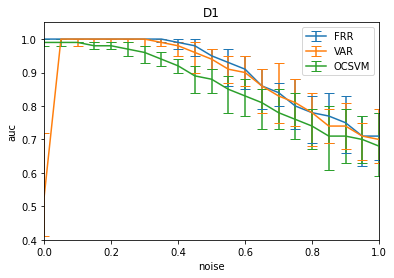

In [4]:
timestamp = datetime.datetime.fromtimestamp(time())
timestamp = timestamp.strftime('%Y-%m-%d_%H-%M-%S')
print(timestamp)
run_noise_experiment_3(timestamp)